In [1]:
import gym
import sys
sys.path.append('./../../')
from game.achtung_process import AchtungProcess
from rl.dqn import get_dqn_model

### DQN

In [3]:
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3 import DQN
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import DummyVecEnv
import torch as th
import torch.nn as nn
import pickle

In [23]:
class CustomCNN(BaseFeaturesExtractor):
    """
    :param observation_space: (gym.Space)
    :param features_dim: (int) Number of features extracted.
        This corresponds to the number of unit for the last layer.
    """

    def __init__(self, observation_space: gym.spaces.Box, features_dim: int = 128):
        super(CustomCNN, self).__init__(observation_space, features_dim)
        # We assume CxHxW images (channels first)
        # Re-ordering will be done by pre-preprocessing or wrapper
        n_input_channels = observation_space.shape[0]
        self.cnn = nn.Sequential(
            nn.Conv2d(n_input_channels, 32, kernel_size=8, stride=4, padding=0),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=0),
            nn.ReLU(),
            nn.Flatten(),
        )

        # Compute shape by doing one forward pass
        with th.no_grad():
            n_flatten = self.cnn(
                th.as_tensor(observation_space.sample()[None]).float()
            ).shape[1]

        self.linear = nn.Sequential(nn.Linear(n_flatten, features_dim), nn.ReLU())

    def forward(self, observations: th.Tensor) -> th.Tensor:
        return self.linear(self.cnn(observations))

policy_kwargs = dict(
    features_extractor_class=CustomCNN,
    features_extractor_kwargs=dict(features_dim=128),
)

In [24]:
env = AchtungProcess(n=1, height=80, width=80)
env.env.speed = 0

In [25]:
model = DQN("CnnPolicy", 
            DummyVecEnv([lambda: env]), 
            policy_kwargs=policy_kwargs,
            buffer_size=10000,
            learning_rate=1e-4,
            batch_size=100,
            learning_starts=100000,
            target_update_interval=1000,
            train_freq=4,
            gradient_steps=1,
            exploration_fraction=0.1,
            exploration_final_eps=0.01)

In [ ]:
model = get_dqn_model()

In [26]:
# Evaluate the initial random policy
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=100)
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

ValueError: could not broadcast input array from shape (80,80,3) into shape (80,80)

In [27]:
import numpy as np

In [18]:
t = np.zeros((3, 80, 80))
print(t.shape)
print(t[:,:,0].shape)

(3, 80, 80)
(3, 80)


In [8]:
# Train
rewards = []
stds = []
for i in range(5):
    print("iteration: ", i+1)
    model.learn(total_timesteps=100)
    mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=100)
    print(f"   mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")
    
    rewards.append(mean_reward)
    stds.append(std_reward)
    
    with open("dqn_reward.txt", "wb") as f:   
        pickle.dump(rewards, f)
    with open("dqn_std.txt", "wb") as f:   
        pickle.dump(stds, f)
print("   saving...")
model.save("dqn_achtung")

iteration:  1


ValueError: could not broadcast input array from shape (130,130) into shape (520,520)

In [9]:
# Evaluate the trained policy
model.load("dqn_achtung")
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=100)
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:38.56 +/- 5.24


In [15]:
obs = env.reset()
model.predict(obs, deterministic=False)

(2, None)

### Graphs

In [10]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Q-learning')

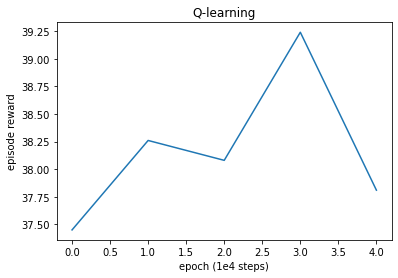

In [11]:
plt.plot(rewards)
plt.xlabel('epoch (1e4 steps)')
plt.ylabel('episode reward')
plt.title('Q-learning')